I've recently started having an interest in beermaking.

Watching a very interesting presentation from EMF Camp 2016 called *Beer for everyone*, I'm now trying to reproduce the setup used by the author to make beer (spoiler: it involves using a classic percolator-type coffee maker).

In [1]:
from IPython.display import IFrame

IFrame("https://media.ccc.de/v/emf2016-269-beer-for-everyone/oembed", width=1024, height=576)

In this process, I've come across the Brewdog catalogue of beer recipes for the home-brewer, called [DIY DOG](https://www.brewdog.com/uk/beers/diy-dog). 

Looking at the recipes, I've realized that a few standard parameters that can be compared between recipes are the mashing temperature and time as well as the fermentation temperature. Since the setup presented in *Beer for everyone* does not indicate strong rules on these parameteres, I'm trying to answer the following question: *How sensitive is the brewery process to these parameters?*. 

One way to answer this is to chart all this information for every recipe in the book. However, the PDF file is not easily machine-readable. Luckily for me, someone already did the hard work of making it machine readable and built a website using it, called [Brewdog recipes](https://brewdogrecipes.com).

So the plan of action is two-fold: get all the data from this website and then chart the three parameters: 

- mashing temperature
- mashing time
- fermentation temperature

# Scraping the data 

We start with the index pages and get the links to the individual recipes. The index pages all have URLs like *https://brewdogrecipes.com/pXX* where *XX* is a number.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

dfs = []
for index in range(14):
    index_url = "https://brewdogrecipes.com/p{}".format(index)
    r = requests.get(index_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    recipes = soup.find('div', class_='recipe-list').find_all('article')
    recipe_urls = [recipe.find('a').attrs['href'] for recipe in recipes]
    recipe_names = [recipe.find('h2').text for recipe in recipes]
    dfs.append(pd.DataFrame({'names': recipe_names, 'urls': recipe_urls }))

df = pd.concat(dfs)

Let's now work with the dataframe we have obtained. Let's make sure there are 249 recipes and then let's extract the data for each recipe.

In [3]:
recipe_df = df.drop_duplicates()

recipe_df.describe()

,names,urls
count,249,249
unique,249,249
top,#244 AB:21,https://brewdogrecipes.com/recipes/b-sides-whi...
freq,1,1


In [4]:
import tqdm

series = []
for recipe_url, name in zip(tqdm.tqdm(recipe_df.urls), recipe_df.names):
    r = requests.get(recipe_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    tag = [item for item in soup.find_all('div', class_='panel panel-brewdog') if item.find(lambda tag: tag.find('h3') and tag.find('h3').text == 'METHOD/TIMINGS') is not None][0]
    items = [item.text for item in tag.find_all('td')]
    try:
        values = {'beer_name': name, 'mash_temp': items[0], 'mash_time': items[2], 'fermentation_temp': items[3]}
    except IndexError:
        print('could not retrieve data for url: {}'.format(recipe_url))
    series.append(pd.Series(values))
    
df_parameters = pd.DataFrame(series)

 21%|█████████████████▏                                                               | 53/249 [00:14<00:53,  3.69it/s]

could not retrieve data for url: https://brewdogrecipes.com/recipes/bramling-x


 35%|████████████████████████████▋                                                    | 88/249 [00:23<00:41,  3.88it/s]

could not retrieve data for url: https://brewdogrecipes.com/recipes/ab-19


 82%|█████████████████████████████████████████████████████████████████▏              | 203/249 [00:55<00:12,  3.66it/s]

could not retrieve data for url: https://brewdogrecipes.com/recipes/no-label


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [01:07<00:00,  3.70it/s]


In [5]:
df_parameters.head()

,beer_name,mash_temp,mash_time,fermentation_temp
0,#1 PUNK IPA 2007 - 2010,65°C,75mins,19°C
1,#2 PUNK IPA 2010 - CURRENT,66°C,75mins,19°C
2,#3 THE PHYSICS,65°C,75mins,19°C
3,#4 RIPTIDE,65°C,75mins,20°C
4,#5 HOP ROCKER,65°C,75mins,10°C


We have all the data we need, let's now get to work with the plotting part.

# Plotting the data 

First, we have to convert the text data to numerical data. 

In [6]:
df = df_parameters.copy()

df['mash_temp'] = df['mash_temp'].str.extract('(.*:?)°C').astype(float)
df['mash_time'] = df['mash_time'].str.extract('(.*:?)mins').astype(float)
df['fermentation_temp'] = df['fermentation_temp'].str.extract('(.*:?)°C').astype(float)

df.head()

,beer_name,mash_temp,mash_time,fermentation_temp
0,#1 PUNK IPA 2007 - 2010,65.0,75.0,19.0
1,#2 PUNK IPA 2010 - CURRENT,66.0,75.0,19.0
2,#3 THE PHYSICS,65.0,75.0,19.0
3,#4 RIPTIDE,65.0,75.0,20.0
4,#5 HOP ROCKER,65.0,75.0,10.0


Let's use this data exploration as an excuse to try out Altair, a relatively recent visualization API. First, let's examine the distribution of each parameter using simple scatter plots.

In [7]:
import altair as alt

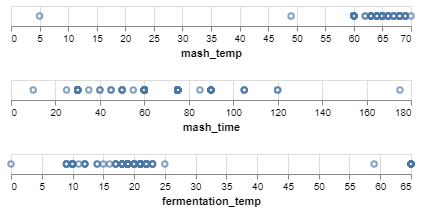

In [8]:
alt.Chart(df).mark_point().encode(
    x='mash_temp',
) & alt.Chart(df).mark_point().encode(
    x='mash_time',
) & alt.Chart(df).mark_point().encode(
    x='fermentation_temp',
)

As we can see, the distribution of mash temperature tends to be clustered around 65°C. The mash time varies a bit more, though, while the fermentation temperature is roughly around normal outside temperature.

Let's see this as histogram charts:

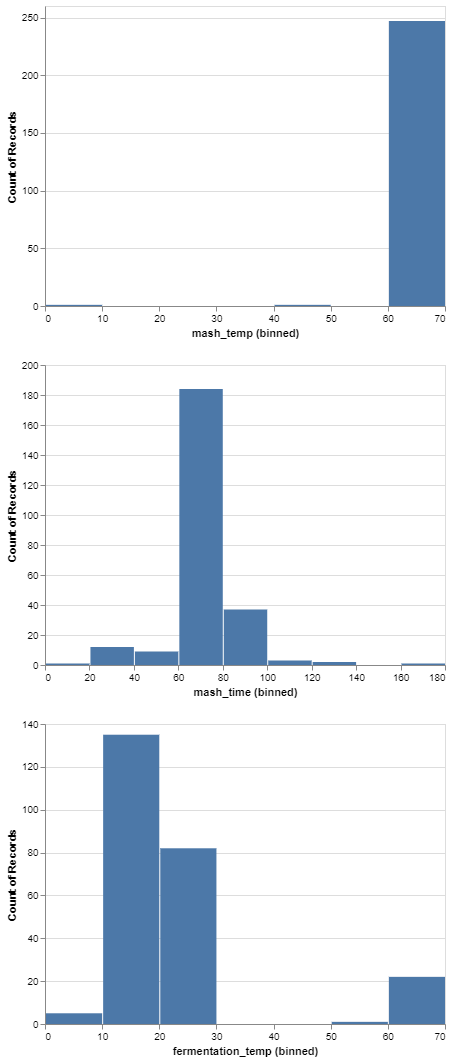

In [9]:
alt.Chart(df).mark_bar().encode(
    alt.X("mash_temp:Q", bin=True),
    y='count()',
) & alt.Chart(df).mark_bar().encode(
    alt.X("mash_time:Q", bin=True),
    y='count()',
) & alt.Chart(df).mark_bar().encode(
    alt.X("fermentation_temp:Q", bin=True),
    y='count()',
)

Finally, we can also combine this and do a two-dimensional chart with tooltip:

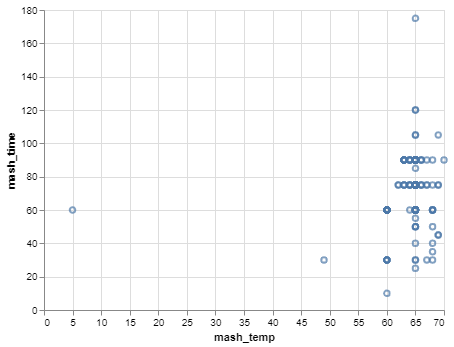

In [10]:
alt.Chart(df).mark_point().encode(
    x='mash_temp',
    y='mash_time',
    tooltip=['beer_name', 'mash_temp', 'mash_time', 'fermentation_temp']
)

In [11]:
df.describe().loc['mean'].to_frame()

,mean
mash_temp,64.405622
mash_time,72.610442
fermentation_temp,23.151020


Apart from a few outliers then, an *average beer* can be obtained with the following parameters:

- mash temperature of 65°C
- mash time of 72 minutes
- fermentation temperature of 23°C

This data-based conclusion is roughly along the lines of what the tutorial for beer making from EMF2016 recommends. 

With this satisfying thought in mind, I can now go back to the main task of brewing beer instead of doing data exploration.

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20190822_BrewdogBeers.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20190822_BrewdogBeers.ipynb).*